In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import json
import pandas as pd
from matplotlib.patches import FancyArrowPatch
from scipy import stats
from scipy.stats import ttest_rel, sem

In [2]:
color_azure = '#0097B2'
color_orange = '#F35000' 
color_blue = '#263985' 
color_blue_2 = '#2176FF'
color_red = '#B00000'
color_yellow = '#FCD116'
color_dark_grey = '#A9A9A9'
color_purple = '#9740A6'
color_light_purple = '#AA8ED6'
color_gold = '#FFD700'
color_gold_2 = '#FFA500' 
pos_color = '#00851D' 
neg_color = '#D01C1C'
color_palette = [color_azure, color_orange, color_blue, color_red, color_yellow, color_dark_grey, color_purple, color_light_purple, color_gold, pos_color, neg_color]

In [3]:
path = 'data/conformal_metrics.json'
path_baseline = 'data/baseline.json'

with open(path, 'r') as f:
    conformal_metrics = json.load(f)

with open(path_baseline, 'r') as f:
    baseline = json.load(f)

### Data Setup

In [4]:
# Define data periods
periods = {
    'Standard': conformal_metrics['vanilla'],
    '6 Months': conformal_metrics['6_months'],
    '1 Year': conformal_metrics['1_year'], 
    '2 Years': conformal_metrics['2_years'],
    '4 Years': conformal_metrics['4_years']
}

periods['Two-Stage (Ours)'] = periods['1 Year'] 

periods_comparison = {k: periods[k] for k in ['Standard', 'Two-Stage (Ours)']}
periods_timeframes = {k: periods[k] for k in ['6 Months', '1 Year', '2 Years', '4 Years']}

# Baseline without two-stage approach
baseline_data = {
        '6M': baseline["6_months"],
        '1Y': baseline["1_year"],
        '2Y': baseline["2_years"],
        '4Y': baseline["4_years"]
}

### Visualization

**Figure 3A, 3B**

Comparison of Coverage and Interval Length Standard vs Two-Stage Conformal across multiple cutoffs

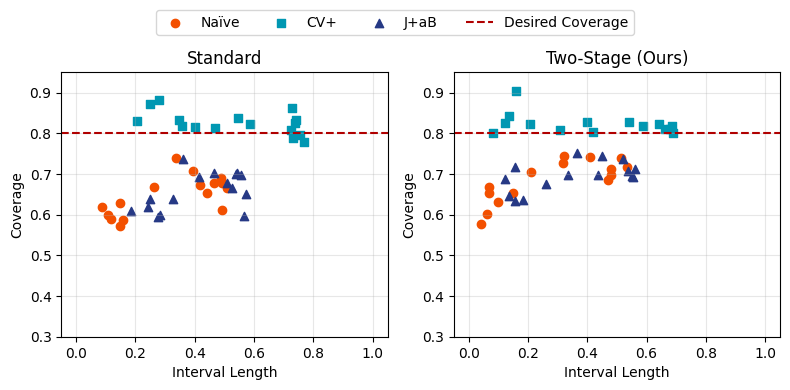

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
for idx, (period, metrics) in enumerate(periods_comparison.items()):
    ax = axs[idx]
    # Plot each strategy's interval width vs. coverage
    ax.scatter(metrics['interval_width_naive'], metrics["coverage_naive"], label="Naïve", marker='o', color=color_palette[1])
    ax.scatter(metrics['interval_width_cv_plus'], metrics["coverage_cv_plus"], label="CV+", marker='s', color=color_palette[0])
    ax.scatter(metrics['interval_width_jackknife_plus_ab'], metrics["coverage_jackknife_plus_ab"], label="J+aB", marker='^', color=color_palette[2])
    ax.axhline(y=0.8, linestyle='--', label="Desired Coverage", color=color_palette[3])
    # Set titles and labels
    ax.set_title(f'{period}', fontsize=12)
    ax.set_xlabel('Interval Length')
    ax.set_ylabel('Coverage')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(0.30, 0.95)

# Adjust layout
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4, fontsize=10, bbox_to_anchor=(0.5, 0.98), frameon=True)
plt.tight_layout(rect=[0, 0, 1, 0.9])  # Leave space for the main title
plt.savefig('cp_standard_ours.svg', transparent=True, bbox_inches='tight')
plt.show()

In [6]:
def bootstrap_confidence_interval(data, n_bootstrap=1000, confidence_level=0.95):
    """
    Compute the bootstrap confidence interval for the mean of the input data.

    Parameters:
        data (array-like): The data to bootstrap.
        n_bootstrap (int): Number of bootstrap samples to draw.
        confidence_level (float): Confidence level for the interval (e.g., 0.95).

    Returns:
        mean (float): The sample mean.
        ci_lower (float): Lower bound of the confidence interval.
        ci_upper (float): Upper bound of the confidence interval.
    """
    data = np.array(data)
    n = len(data)
    
    # Generate bootstrap samples
    bootstrap_means = []
    for _ in range(n_bootstrap):  # Fixed the syntax error
        bootstrap_sample = np.random.choice(data, size=n, replace=True)
        bootstrap_means.append(np.mean(bootstrap_sample))
    
    bootstrap_means = np.array(bootstrap_means)
    
    # Calculate confidence interval
    alpha = 1 - confidence_level
    ci_lower = np.percentile(bootstrap_means, 100 * alpha/2)
    ci_upper = np.percentile(bootstrap_means, 100 * (1 - alpha/2))
    
    return np.mean(data), ci_lower, ci_upper

def calculate_bootstrap_metrics(metrics_dict, n_bootstrap=1000, confidence_level=0.95):
    """
    Calculate bootstrap means and confidence intervals for all relevant metrics.

    Parameters:
        metrics_dict (dict): Dictionary with metric names as keys and lists of values.
        n_bootstrap (int): Number of bootstrap samples.
        confidence_level (float): Confidence level for the intervals.

    Returns:
        dict: Dictionary with metric names as keys and dicts with mean, ci_lower, ci_upper, ci_width.
    """
    results = {}
    
    for metric_name in ['coverage_naive', 'coverage_cv_plus', 'coverage_jackknife_plus_ab',
                       'interval_width_naive', 'interval_width_cv_plus', 'interval_width_jackknife_plus_ab']:
        mean, ci_lower, ci_upper = bootstrap_confidence_interval(
            metrics_dict[metric_name], n_bootstrap, confidence_level
        )
        results[metric_name] = {
            'mean': mean,
            'ci_lower': ci_lower,
            'ci_upper': ci_upper,
            'ci_width': ci_upper - ci_lower
        }
    
    return results

def calculate_average_metrics(metrics_dict):
    """
    Compute the mean for each metric in the provided dictionary.

    Parameters:
        metrics_dict (dict): Dictionary with metric names as keys and lists of values.

    Returns:
        dict: Dictionary with metric names as keys and their mean as values.
    """    
    return {
        'coverage_naive': np.mean(metrics_dict['coverage_naive']),
        'coverage_cv_plus': np.mean(metrics_dict['coverage_cv_plus']),
        'coverage_jackknife_plus_ab': np.mean(metrics_dict['coverage_jackknife_plus_ab']),
        'interval_width_naive': np.mean(metrics_dict['interval_width_naive']),
        'interval_width_cv_plus': np.mean(metrics_dict['interval_width_cv_plus']),
        'interval_width_jackknife_plus_ab': np.mean(metrics_dict['interval_width_jackknife_plus_ab'])
    }

def extract_values_and_errors(bootstrap_results, metric_names):
    """
    Extract means and error bars (lower and upper) for a list of metrics from bootstrap results.

    Parameters:
        bootstrap_results (dict): Output from calculate_bootstrap_metrics.
        metric_names (list): List of metric names to extract.

    Returns:
        tuple: (means, lower_errors, upper_errors), each a list of floats.
    """
    means = [bootstrap_results[name]['mean'] for name in metric_names]
    lower_errors = [bootstrap_results[name]['mean'] - bootstrap_results[name]['ci_lower'] 
                   for name in metric_names]
    upper_errors = [bootstrap_results[name]['ci_upper'] - bootstrap_results[name]['mean'] 
                   for name in metric_names]
    return means, lower_errors, upper_errors

**Figure 3A-D. Full comparison of Standard vs Two-Stage Conformal**

(A-D) compare standard and our two-stage conformal approach. (A) and (B) show coverage vs. interval length at different classification cutoffs. (C-D) shows  comparison of marginal coverage (higher is better) and mean interval length (lower is better) with bootstrap confidence intervals for Naïve, CV+, and J+aB.

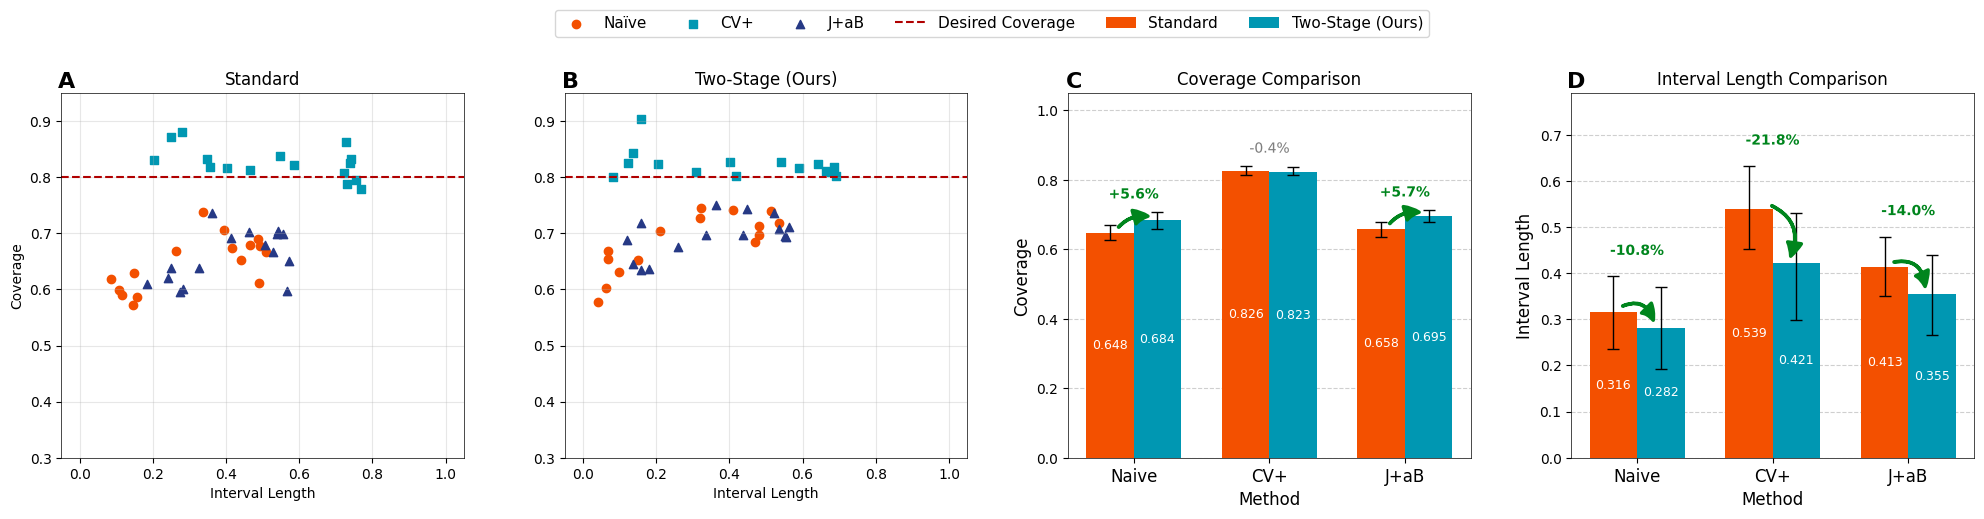

In [7]:
# Set seed for reproducibility
np.random.seed(42)
# Calculate bootstrap statistics
vanilla_bootstrap = calculate_bootstrap_metrics(periods['Standard'])
full_bootstrap = calculate_bootstrap_metrics(periods['Two-Stage (Ours)'])

# Calculate the averages for the bar charts (keep for compatibility)
vanilla_avg = calculate_average_metrics(periods['Standard'])
full_avg = calculate_average_metrics(periods['Two-Stage (Ours)'])

# Calculate percentage differences using bootstrap means
diff_coverage_naive = (full_bootstrap['coverage_naive']['mean'] - vanilla_bootstrap['coverage_naive']['mean']) / vanilla_bootstrap['coverage_naive']['mean'] * 100
diff_coverage_cv_plus = (full_bootstrap['coverage_cv_plus']['mean'] - vanilla_bootstrap['coverage_cv_plus']['mean']) / vanilla_bootstrap['coverage_cv_plus']['mean'] * 100
diff_coverage_jackknife = (full_bootstrap['coverage_jackknife_plus_ab']['mean'] - vanilla_bootstrap['coverage_jackknife_plus_ab']['mean']) / vanilla_bootstrap['coverage_jackknife_plus_ab']['mean'] * 100

diff_interval_naive = (vanilla_bootstrap['interval_width_naive']['mean'] - full_bootstrap['interval_width_naive']['mean']) / vanilla_bootstrap['interval_width_naive']['mean'] * 100
diff_interval_cv_plus = (vanilla_bootstrap['interval_width_cv_plus']['mean'] - full_bootstrap['interval_width_cv_plus']['mean']) / vanilla_bootstrap['interval_width_cv_plus']['mean'] * 100
diff_interval_jackknife = (vanilla_bootstrap['interval_width_jackknife_plus_ab']['mean'] - full_bootstrap['interval_width_jackknife_plus_ab']['mean']) / vanilla_bootstrap['interval_width_jackknife_plus_ab']['mean'] * 100

# Create the combined figure with 1x4 subplots
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
plt.rcParams.update({'font.size': 12})  # Set base font size

# First two scatter plots (from the first code snippet)
for idx, (period, metrics) in enumerate(periods_comparison.items()):
    ax = axs[idx]  # First two subplots
    
    # Plot each strategy's interval width vs. coverage
    ax.scatter(metrics['interval_width_naive'], metrics["coverage_naive"], 
               label="Naïve", marker='o', color=color_palette[1])
    ax.scatter(metrics['interval_width_cv_plus'], metrics["coverage_cv_plus"], 
               label="CV+", marker='s', color=color_palette[0])
    ax.scatter(metrics['interval_width_jackknife_plus_ab'], metrics["coverage_jackknife_plus_ab"], 
               label="J+aB", marker='^', color=color_palette[2])
    ax.axhline(y=0.8, linestyle='--', label="Desired Coverage", color=color_palette[3])
    
    # Set titles and labels
    ax.set_title(f'{period}', fontsize=12)
    ax.set_xlabel('Interval Length')
    ax.set_ylabel('Coverage' if idx == 0 else '')  # Only show y-label on first plot
    ax.grid(True, alpha=0.3)
    
    # Set axis limits
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(0.30, 0.95)
    
    # Add panel letter
    ax.text(0.035, 1.06, chr(65+idx), transform=ax.transAxes,
           fontsize=16, fontweight='bold', va='top', ha='right')

# Bar charts with bootstrap confidence intervals
width = 0.35  # Slightly narrower bars for better spacing
methods = ['Naive', 'CV+', 'J+aB']
x = np.arange(len(methods))

# Coverage Comparison with confidence intervals (Panel C)
ax1 = axs[2]  # Third subplot

# Extract coverage data with bootstrap confidence intervals
coverage_metrics = ['coverage_naive', 'coverage_cv_plus', 'coverage_jackknife_plus_ab']
vanilla_coverage, vanilla_coverage_lower, vanilla_coverage_upper = extract_values_and_errors(vanilla_bootstrap, coverage_metrics)
full_coverage, full_coverage_lower, full_coverage_upper = extract_values_and_errors(full_bootstrap, coverage_metrics)

# Format values to 3 decimal places for consistency
vanilla_coverage_formatted = [f"{val:.3f}" for val in vanilla_coverage]
full_coverage_formatted = [f"{val:.3f}" for val in full_coverage]

# Create bars with visible error bars
bar1 = ax1.bar(x - width/2, vanilla_coverage, width, label='Standard', color=color_orange, zorder=5,
               yerr=[vanilla_coverage_lower, vanilla_coverage_upper], capsize=4, 
               error_kw={'zorder': 8, 'linewidth': 1, 'capthick': 1, 'color': 'black'})
bar2 = ax1.bar(x + width/2, full_coverage, width, label='Two-Stage (Ours)', color=color_azure, zorder=5,
               yerr=[full_coverage_lower, full_coverage_upper], capsize=4, 
               error_kw={'zorder': 8, 'linewidth': 1, 'capthick': 1, 'color': 'black'})

# Function to add centered labels in bars
def add_centered_labels(bars, formatted_values, ax):
    """
    Add centered value labels to bar plots.

    Parameters:
        bars: BarContainer object from matplotlib.
        formatted_values (list): List of string-formatted values to display.
        ax: The matplotlib axis to annotate.
    """
    for bar, value in zip(bars, formatted_values):
        height = bar.get_height()
        # Position labels in the center of the bars
        ax.text(bar.get_x() + bar.get_width()/2., height/2,
                value, ha='center', va='center', fontsize=9, zorder=15,
                color='white')

add_centered_labels(bar1, vanilla_coverage_formatted, ax1)
add_centered_labels(bar2, full_coverage_formatted, ax1)

# Calculate y-axis limits accounting for error bars with reasonable padding
max_coverage_with_error = max(
    max([v + e for v, e in zip(vanilla_coverage, vanilla_coverage_upper)]),
    max([v + e for v, e in zip(full_coverage, full_coverage_upper)])
)
ax1.set_ylim(0, max_coverage_with_error * 1.25)

ax1.set_xticks(x)
ax1.set_xticklabels(methods, fontsize=12)
ax1.set_xlabel('Method', fontsize=12)
ax1.set_ylabel('Coverage', fontsize=12)
ax1.set_title('Coverage Comparison', fontsize=12)

# Reduce number of grid lines for less clutter
ax1.grid(axis='y', linestyle='--', alpha=0.6, zorder=1)
ax1.set_axisbelow(True)

# Add panel letter
ax1.text(0.035, 1.06, 'C', transform=ax1.transAxes,
        fontsize=16, fontweight='bold', va='top', ha='right')

# Interval Width with confidence intervals (Panel D)
ax2 = axs[3]  # Fourth subplot

# Extract interval width data with bootstrap confidence intervals
interval_metrics = ['interval_width_naive', 'interval_width_cv_plus', 'interval_width_jackknife_plus_ab']
vanilla_interval, vanilla_interval_lower, vanilla_interval_upper = extract_values_and_errors(vanilla_bootstrap, interval_metrics)
full_interval, full_interval_lower, full_interval_upper = extract_values_and_errors(full_bootstrap, interval_metrics)

# Format values to 3 decimal places for consistency
vanilla_interval_formatted = [f"{val:.3f}" for val in vanilla_interval]
full_interval_formatted = [f"{val:.3f}" for val in full_interval]

# Create bars with visible error bars
bar3 = ax2.bar(x - width/2, vanilla_interval, width, color=color_orange, zorder=5,
               yerr=[vanilla_interval_lower, vanilla_interval_upper], capsize=4, 
               error_kw={'zorder': 8, 'linewidth': 1, 'capthick': 1, 'color': 'black'})
bar4 = ax2.bar(x + width/2, full_interval, width, color=color_azure, zorder=5,
               yerr=[full_interval_lower, full_interval_upper], capsize=4, 
               error_kw={'zorder': 8, 'linewidth': 1, 'capthick': 1, 'color': 'black'})

add_centered_labels(bar3, vanilla_interval_formatted, ax2)
add_centered_labels(bar4, full_interval_formatted, ax2)

# Calculate y-axis limits accounting for error bars with reasonable padding
max_interval_with_error = max(
    max([v + e for v, e in zip(vanilla_interval, vanilla_interval_upper)]),
    max([v + e for v, e in zip(full_interval, full_interval_upper)])
)
ax2.set_ylim(0, max_interval_with_error * 1.25)

ax2.set_xticks(x)
ax2.set_xticklabels(methods, fontsize=12)
ax2.set_xlabel('Method', fontsize=12)
ax2.set_ylabel('Interval Length', fontsize=12)
ax2.set_title('Interval Length Comparison', fontsize=12)

# Reduce number of grid lines for less clutter
ax2.grid(axis='y', linestyle='--', alpha=0.6, zorder=1)
ax2.set_axisbelow(True)

# Add panel letter
ax2.text(0.035, 1.06, 'D', transform=ax2.transAxes,
        fontsize=16, fontweight='bold', va='top', ha='right')

# Arrows and labels 
arrow_style = "simple,head_width=10,head_length=10"
arrow_linewidth = 2.5

# Add curved arrows
coverage_diffs = [diff_coverage_naive, diff_coverage_cv_plus, diff_coverage_jackknife]
interval_diffs = [diff_interval_naive, diff_interval_cv_plus, diff_interval_jackknife]

for i, (diff_cov, diff_int) in enumerate(zip(coverage_diffs, interval_diffs)):
    # Coverage arrows and annotations
    vanilla_bar_top = vanilla_coverage[i]
    full_bar_top = full_coverage[i]
    arrow_center_x = x[i]
    
    # Account for error bars in positioning
    vanilla_error_top = vanilla_bar_top + vanilla_coverage_upper[i]
    full_error_top = full_bar_top + full_coverage_upper[i]
    
    # For coverage: higher is better
    if diff_cov > 1.0:  # Only show significant improvements (>1%)
        # Draw curved arrow starting from bar tops
        arrow = FancyArrowPatch(
            (arrow_center_x - width/2 + 0.05, vanilla_bar_top + 0.01), 
            (arrow_center_x + width/2 - 0.05, full_bar_top + 0.01),
            connectionstyle=f"arc3,rad=-0.3", 
            arrowstyle=arrow_style, 
            color=pos_color, 
            linewidth=arrow_linewidth,
            zorder=15
        )
        ax1.add_patch(arrow)
        
        # Position text well above error bars
        text = ax1.text(arrow_center_x, max(vanilla_error_top, full_error_top) + 0.03,
                f'+{abs(diff_cov):.1f}%', ha='center', va='bottom', 
                fontsize=10, color=pos_color, fontweight='bold', zorder=20)
        text.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='white')])
    elif diff_cov < -1.0:  # Only show significant decreases (<-1%)
        arrow = FancyArrowPatch(
            (arrow_center_x - width/2 + 0.05, vanilla_bar_top + 0.01), 
            (arrow_center_x + width/2 - 0.05, full_bar_top + 0.01),
            connectionstyle=f"arc3,rad=-0.3", 
            arrowstyle=arrow_style, 
            color=neg_color, 
            linewidth=arrow_linewidth,
            zorder=15
        )
        ax1.add_patch(arrow)
        
        text = ax1.text(arrow_center_x, max(vanilla_error_top, full_error_top) + 0.03,
                f'{diff_cov:.1f}%', ha='center', va='bottom', 
                fontsize=10, color=neg_color, fontweight='bold', zorder=20)
        text.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='white')])
    else:
        # For small differences, show a muted label
        text = ax1.text(arrow_center_x, max(vanilla_error_top, full_error_top) + 0.03,
                f'{diff_cov:.1f}%', ha='center', va='bottom', 
                fontsize=10, color='#666666', fontweight='normal', alpha=0.8, zorder=20)
        text.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='white')])
    
    # Interval width arrows and annotations
    vanilla_bar_top_int = vanilla_interval[i]
    full_bar_top_int = full_interval[i]
    vanilla_error_top_int = vanilla_bar_top_int + vanilla_interval_upper[i]
    full_error_top_int = full_bar_top_int + full_interval_upper[i]
    
    # For interval: lower is better
    if diff_int > 0:  # Full conformal has shorter interval (better)
        # Adjust arrow positioning for different methods
        start_x_offset = 0.05
        end_x_offset = 0.05
        curve_rad = -0.6
        
        if i == 1:  # CV+ method
            start_x_offset = 0.15
            end_x_offset = 0.05
            curve_rad = -0.5
        
        # Draw curved arrow starting from bar tops
        arrow = FancyArrowPatch(
            (arrow_center_x - width/2 + start_x_offset, vanilla_bar_top_int + 0.01), 
            (arrow_center_x + width/2 - end_x_offset, full_bar_top_int + 0.01),
            connectionstyle=f"arc3,rad={curve_rad}", 
            arrowstyle=arrow_style, 
            color=pos_color, 
            linewidth=arrow_linewidth,
            zorder=15
        )
        ax2.add_patch(arrow)
        
        # Position text well above error bars
        text = ax2.text(arrow_center_x, max(vanilla_error_top_int, full_error_top_int) + 0.04,
                f'-{abs(diff_int):.1f}%', ha='center', va='bottom', 
                fontsize=10, color=pos_color, fontweight='bold', zorder=20)
        text.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='white')])

# Add common legend
handles1, labels1 = axs[0].get_legend_handles_labels()
handles2, labels2 = ax1.get_legend_handles_labels()
all_handles = handles1 + handles2
all_labels = labels1 + labels2

# Remove duplicates while preserving order
unique_labels = []
unique_handles = []
for handle, label in zip(all_handles, all_labels):
    if label not in unique_labels:
        unique_labels.append(label)
        unique_handles.append(handle)

fig.legend(unique_handles, unique_labels, loc='upper center', ncol=6, 
           fontsize=11, bbox_to_anchor=(0.5, 1.05), frameon=True)

# Adjust borders and layout
for ax in axs:
    for spine in ax.spines.values():
        spine.set_color('black')
        spine.set_linewidth(0.5)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave room for the legend
plt.subplots_adjust(wspace=0.25)  # Add space between subplots
plt.savefig('combined_visualization_with_ci.svg', dpi=400, bbox_inches='tight')
plt.show()

**Figure 4: Uncertainty Quantification across time horizons (6M, 1Y, 2Y, 4Y)**

Uncertainty quantification across time horizons (6 months, 1 year, 2 years, 4 years) for Naïve, CV+, and J+aB. Prediction uncertainty changes over progressively longer forecasting periods

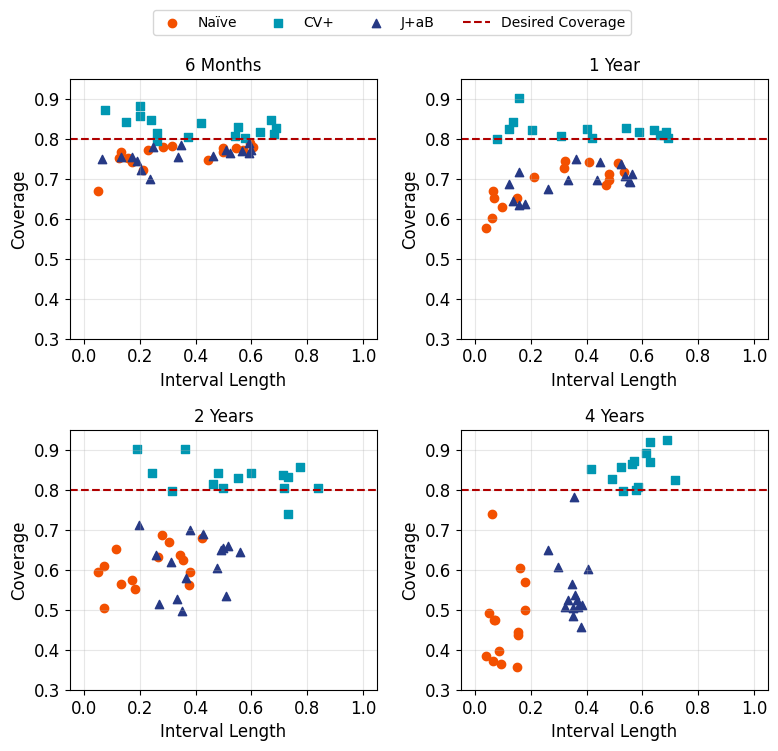

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
for idx, (period, metrics) in enumerate(periods_timeframes.items()):
    row, col = divmod(idx, 2)  # Get subplot row and column
    ax = axs[row, col]  # Select appropriate subplot

    # Plot each strategy's interval width vs. coverage
    ax.scatter(metrics['interval_width_naive'], metrics["coverage_naive"], label="Naïve", marker='o', color=color_palette[1])
    ax.scatter(metrics['interval_width_cv_plus'], metrics["coverage_cv_plus"], label="CV+", marker='s', color=color_palette[0])
    ax.scatter(metrics['interval_width_jackknife_plus_ab'], metrics["coverage_jackknife_plus_ab"], label="J+aB", marker='^', color=color_palette[2])
    ax.axhline(y=0.8, linestyle='--', label="Desired Coverage", color=color_palette[3])
    # Set titles and labels
    ax.set_title(f'{period}', fontsize=12)
    ax.set_xlabel('Interval Length')
    ax.set_ylabel('Coverage')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(0.30, 0.95)

# Adjust layout
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4, fontsize=10, bbox_to_anchor=(0.5, 0.945), frameon=True)
plt.tight_layout(rect=[0, 0, 1, 0.9])  # Leave space for the main title
plt.savefig('cp_over_time.svg', transparent=True, bbox_inches='tight')
plt.show()

### Bootstrap and Paired t-test analysis

Performance Results with 95% Bootstrap Confidence Intervals (1000 resamples), and Two-Stage performance changes for both coverage and interval length.

In [9]:
# Calculate t-test results
def get_ttest_results(periods_data):
    """Get t-test results using your original data structure."""
    results = {}
    
    coverage_methods = ['coverage_naive', 'coverage_cv_plus', 'coverage_jackknife_plus_ab']
    interval_methods = ['interval_width_naive', 'interval_width_cv_plus', 'interval_width_jackknife_plus_ab']
    method_names = ['Naive', 'CV+', 'J+aB']
    
    # Coverage t-tests
    for method, name in zip(coverage_methods, method_names):
        try:
            standard_data = np.array(periods_data['Standard'][method])
            twostage_data = np.array(periods_data['Two-Stage (Ours)'][method])
            
            # Align lengths if needed
            min_length = min(len(standard_data), len(twostage_data))
            standard_data = standard_data[:min_length]
            twostage_data = twostage_data[:min_length]
            
            # Remove NaN pairs
            valid_mask = ~(np.isnan(standard_data) | np.isnan(twostage_data))
            standard_clean = standard_data[valid_mask]
            twostage_clean = twostage_data[valid_mask]
            
            # Paired t-test (Two-Stage vs Standard for coverage)
            t_stat, p_val = ttest_rel(twostage_clean, standard_clean)
            
            # Effect size
            differences = twostage_clean - standard_clean
            cohens_d = np.mean(differences) / np.std(differences, ddof=1)
            
            results[f'{name}_coverage'] = {
                't': t_stat, 'p': p_val, 'd': cohens_d, 'n': len(standard_clean)
            }
            
        except Exception as e:
            print(f"Error with {name} coverage: {e}")
    
    # Interval t-tests
    for method, name in zip(interval_methods, method_names):
        try:
            standard_data = np.array(periods_data['Standard'][method])
            twostage_data = np.array(periods_data['Two-Stage (Ours)'][method])
            
            # Align lengths if needed
            min_length = min(len(standard_data), len(twostage_data))
            standard_data = standard_data[:min_length]
            twostage_data = twostage_data[:min_length]
            
            # Remove NaN pairs
            valid_mask = ~(np.isnan(standard_data) | np.isnan(twostage_data))
            standard_clean = standard_data[valid_mask]
            twostage_clean = twostage_data[valid_mask]
            
            # Paired t-test (Standard vs Two-Stage for intervals - lower is better)
            t_stat, p_val = ttest_rel(standard_clean, twostage_clean)
            
            # Effect size
            differences = standard_clean - twostage_clean
            cohens_d = np.mean(differences) / np.std(differences, ddof=1)
            
            results[f'{name}_interval'] = {
                't': t_stat, 'p': p_val, 'd': cohens_d, 'n': len(standard_clean)
            }
            
        except Exception as e:
            print(f"Error with {name} interval: {e}")
    
    return results

# Get t-test results
ttest_results = get_ttest_results(periods)

# Organize data for tables
method_names = ['Naive', 'CV+', 'J+aB']
coverage_methods = ['coverage_naive', 'coverage_cv_plus', 'coverage_jackknife_plus_ab']
interval_methods = ['interval_width_naive', 'interval_width_cv_plus', 'interval_width_jackknife_plus_ab']

coverage_stats = {}
interval_stats = {}

for i, name in enumerate(method_names):
    cov_method = coverage_methods[i]
    int_method = interval_methods[i]
    
    # Coverage stats
    coverage_stats[name] = {
        'std_mean': vanilla_bootstrap[cov_method]['mean'],
        'std_ci_lower': vanilla_bootstrap[cov_method]['ci_lower'],
        'std_ci_upper': vanilla_bootstrap[cov_method]['ci_upper'],
        'two_mean': full_bootstrap[cov_method]['mean'],
        'two_ci_lower': full_bootstrap[cov_method]['ci_lower'],
        'two_ci_upper': full_bootstrap[cov_method]['ci_upper'],
        'difference': full_bootstrap[cov_method]['mean'] - vanilla_bootstrap[cov_method]['mean'],
        'rel_improvement': ((full_bootstrap[cov_method]['mean'] - vanilla_bootstrap[cov_method]['mean']) / vanilla_bootstrap[cov_method]['mean']) * 100
    }
    
    # Add t-test results if available
    ttest_key = f'{name}_coverage'
    if ttest_key in ttest_results:
        coverage_stats[name].update(ttest_results[ttest_key])
    
    # Interval stats  
    interval_stats[name] = {
        'std_mean': vanilla_bootstrap[int_method]['mean'],
        'std_ci_lower': vanilla_bootstrap[int_method]['ci_lower'],
        'std_ci_upper': vanilla_bootstrap[int_method]['ci_upper'],
        'two_mean': full_bootstrap[int_method]['mean'],
        'two_ci_lower': full_bootstrap[int_method]['ci_lower'],
        'two_ci_upper': full_bootstrap[int_method]['ci_upper'],
        'difference': vanilla_bootstrap[int_method]['mean'] - full_bootstrap[int_method]['mean'],
        'rel_improvement': ((vanilla_bootstrap[int_method]['mean'] - full_bootstrap[int_method]['mean']) / vanilla_bootstrap[int_method]['mean']) * 100
    }
    
    # Add t-test results if available
    ttest_key = f'{name}_interval'
    if ttest_key in ttest_results:
        interval_stats[name].update(ttest_results[ttest_key])

In [10]:
def make_performance_table(
    stats_dict, 
    method_names, 
    mean_label="Standard Mean", 
    ci_label="Standard 95% CI", 
    two_mean_label="Two-Stage Mean", 
    two_ci_label="Two-Stage 95% CI", 
    abs_label="Absolute Change", 
    rel_label="Relative Change"
):
    """
    Helper to generate a performance table for coverage or interval metrics.
    """
    rows = []
    for name in method_names:
        stats = stats_dict[name]
        if 't' in stats:
            p_val = stats['p']
            if p_val < 0.001:
                sig_level = "***"
            elif p_val < 0.01:
                sig_level = "**"
            elif p_val < 0.05:
                sig_level = "*"
            else:
                sig_level = "ns"
            stat_result = f"{sig_level} (d={stats['d']:.3f})"
        else:
            stat_result = "Not tested"
        rows.append({
            "Method": name,
            mean_label: round(stats['std_mean'], 3),
            ci_label: f"[{stats['std_ci_lower']:.3f}, {stats['std_ci_upper']:.3f}]",
            two_mean_label: round(stats['two_mean'], 3),
            two_ci_label: f"[{stats['two_ci_lower']:.3f}, {stats['two_ci_upper']:.3f}]",
            abs_label: f"{stats['difference']:+.3f}",
            rel_label: f"{stats['rel_improvement']:+.1f}%",
            "Statistical Result": stat_result
        })
    return pd.DataFrame(rows)

**Table 5A: Coverage Performance (Descriptive Statistics, Bootstrap, and Statistical Results)**

Shows the mean, 95% bootstrap confidence interval, absolute and relative change, and statistical test results for coverage across all methods.

In [11]:
df_coverage = make_performance_table(
    coverage_stats, 
    method_names, 
    mean_label="Standard Mean", 
    ci_label="Standard 95% CI", 
    two_mean_label="Two-Stage Mean", 
    two_ci_label="Two-Stage 95% CI", 
    abs_label="Absolute Change", 
    rel_label="Relative Change"
)
df_coverage

,Method,Standard Mean,Standard 95% CI,Two-Stage Mean,Two-Stage 95% CI,Absolute Change,Relative Change,Statistical Result
0,Naive,0.648,"[0.626, 0.670]",0.684,"[0.658, 0.708]",+0.036,+5.6%,** (d=0.813)
1,CV+,0.826,"[0.814, 0.840]",0.823,"[0.813, 0.836]",-0.003,-0.4%,ns (d=-0.067)
2,J+aB,0.658,"[0.637, 0.678]",0.695,"[0.678, 0.713]",+0.037,+5.7%,** (d=1.045)


**Table 5B: Interval Length Performance (Descriptive Statistics, Bootstrap, and Statistical Results)**

Shows the mean, 95% bootstrap confidence interval, absolute and relative reduction, and statistical test results for interval length across all methods.


In [12]:
df_interval = make_performance_table(
    interval_stats, 
    method_names, 
    mean_label="Standard Mean", 
    ci_label="Standard 95% CI", 
    two_mean_label="Two-Stage Mean", 
    two_ci_label="Two-Stage 95% CI", 
    abs_label="Absolute Reduction", 
    rel_label="Relative Reduction"
)
df_interval

,Method,Standard Mean,Standard 95% CI,Two-Stage Mean,Two-Stage 95% CI,Absolute Reduction,Relative Reduction,Statistical Result
0,Naive,0.316,"[0.235, 0.393]",0.282,"[0.193, 0.371]",+0.034,+10.8%,* (d=0.756)
1,CV+,0.539,"[0.453, 0.632]",0.421,"[0.298, 0.531]",+0.117,+21.8%,*** (d=1.630)
2,J+aB,0.413,"[0.350, 0.479]",0.355,"[0.267, 0.439]",+0.058,+14.0%,** (d=1.065)


**Table 6: Paired t-test and Effect Sizes**

Summarizes paired t-test results and effect sizes (Cohen's d) for coverage and interval length, comparing Standard and Two-Stage methods for each conformal strategy.

In [13]:
ttest_rows = []
for name in method_names:
    # Coverage
    if 't' in coverage_stats[name]:
        stats = coverage_stats[name]
        p_val = stats['p']
        if p_val < 0.001:
            p_text, sig_level = "p < 0.001", "***"
        elif p_val < 0.01:
            p_text, sig_level = f"p = {p_val:.3f}", "**"
        elif p_val < 0.05:
            p_text, sig_level = f"p = {p_val:.3f}", "*"
        else:
            p_text, sig_level = f"p = {p_val:.3f}", "ns"
        abs_d = abs(stats['d'])
        if abs_d >= 0.8:
            effect_size = "Large"
        elif abs_d >= 0.5:
            effect_size = "Medium"
        elif abs_d >= 0.2:
            effect_size = "Small"
        else:
            effect_size = "Negligible"
        ttest_rows.append({
            "Comparison": f"{name} Coverage",
            "n": stats.get('n', 15),
            "t-statistic": round(stats['t'], 3),
            "p-value": p_text,
            "Significance": sig_level,
            "Cohen's d": round(stats['d'], 3),
            "Effect Size": effect_size
        })
    # Interval
    if 't' in interval_stats[name]:
        stats = interval_stats[name]
        p_val = stats['p']
        if p_val < 0.001:
            p_text, sig_level = "p < 0.001", "***"
        elif p_val < 0.01:
            p_text, sig_level = f"p = {p_val:.3f}", "**"
        elif p_val < 0.05:
            p_text, sig_level = f"p = {p_val:.3f}", "*"
        else:
            p_text, sig_level = f"p = {p_val:.3f}", "ns"
        abs_d = abs(stats['d'])
        if abs_d >= 0.8:
            effect_size = "Large"
        elif abs_d >= 0.5:
            effect_size = "Medium"
        elif abs_d >= 0.2:
            effect_size = "Small"
        else:
            effect_size = "Negligible"
        ttest_rows.append({
            "Comparison": f"{name} Interval",
            "n": stats.get('n', 15),
            "t-statistic": round(stats['t'], 3),
            "p-value": p_text,
            "Significance": sig_level,
            "Cohen's d": round(stats['d'], 3),
            "Effect Size": effect_size
        })
df_ttest = pd.DataFrame(ttest_rows)
df_ttest

,Comparison,n,t-statistic,p-value,Significance,Cohen's d,Effect Size
0,Naive Coverage,15,3.150,p = 0.007,**,0.813,Large
1,Naive Interval,15,2.929,p = 0.011,*,0.756,Medium
2,CV+ Coverage,15,-0.258,p = 0.800,ns,-0.067,Negligible
3,CV+ Interval,15,6.313,p < 0.001,***,1.630,Large
4,J+aB Coverage,15,4.048,p = 0.001,**,1.045,Large
5,J+aB Interval,15,4.124,p = 0.001,**,1.065,Large


### Baseline (Standard-Single Stage) Comparison

Baseline Comparison: Standard (Single-Stage) vs Two-Stage Conformal Prediction. Bolded pairs of coverage and interval length represent the best performing method per time window. Our approach provides reliable coverage (higher is better) with competitive interval lengths (lower is better).

In [14]:
period_keys = ['6M', '1Y', '2Y', '4Y']
conformal_metrics_key_map = {
    '6M': conformal_metrics['6_months'],
    '1Y': conformal_metrics['1_year'],
    '2Y': conformal_metrics['2_years'],
    '4Y': conformal_metrics['4_years'],
}
optimal_cutoff_map = {
    '6M': 0.95,
    '1Y': 0.95,
    '2Y': 0.95,
    '4Y': 0.85,
}
method_mapping = [
    ('Naïve', 'naive'),
    ('CV+', 'cv_plus'),
    ('J+aB', 'jackknife_plus_ab')
]

comparison_rows = []
for period_key in period_keys:
    baseline = baseline_data[period_key]
    metrics = conformal_metrics_key_map[period_key]
    cutoff_list = metrics['cutoff']
    # Find the index of the optimal cutoff for this period
    try:
        cutoff_idx = cutoff_list.index(optimal_cutoff_map[period_key])
    except ValueError:
        # If not found, use the closest cutoff
        cutoff_idx = min(range(len(cutoff_list)), key=lambda i: abs(cutoff_list[i] - optimal_cutoff_map[period_key]))
    for method_name, method_key in method_mapping:
        baseline_cov = baseline[f'coverage_{method_key}']
        baseline_int = baseline[f'interval_width_{method_key}']
        optimal_cov = metrics[f'coverage_{method_key}'][cutoff_idx]
        optimal_int = metrics[f'interval_width_{method_key}'][cutoff_idx]
        cov_diff = optimal_cov - baseline_cov
        int_diff = optimal_int - baseline_int  # <-- Corrected sign: negative means improvement
        comparison_rows.append({
            'Time': period_key,
            'Method': method_name,
            'Standard Coverage': f"{baseline_cov:.3f}",
            'Standard Interval': f"{baseline_int:.3f}",
            'Two-Stage Coverage': f"{optimal_cov:.3f}",
            'Two-Stage Interval': f"{optimal_int:.3f}",
            'Coverage Δ': f"{cov_diff:+.3f}",
            'Interval Δ': f"{int_diff:+.3f}"  # Now negative means shorter (better)
        })
df_comparison = pd.DataFrame(comparison_rows)
df_comparison

,Time,Method,Standard Coverage,Standard Interval,Two-Stage Coverage,Two-Stage Interval,Coverage Δ,Interval Δ
0,6M,Naïve,0.772,0.219,0.670,0.052,-0.102,-0.167
1,6M,CV+,0.794,0.264,0.873,0.075,+0.080,-0.190
2,6M,J+aB,0.777,0.239,0.751,0.064,-0.026,-0.174
3,1Y,Naïve,0.733,0.322,0.578,0.041,-0.155,-0.281
4,1Y,CV+,0.811,0.460,0.800,0.082,-0.011,-0.378
5,1Y,J+aB,0.750,0.375,0.689,0.122,-0.061,-0.254
6,2Y,Naïve,0.664,0.226,0.596,0.051,-0.068,-0.175
7,2Y,CV+,0.811,0.811,0.904,0.192,+0.092,-0.619
8,2Y,J+aB,0.703,0.703,0.712,0.200,+0.009,-0.503
9,4Y,Naïve,0.536,0.142,0.739,0.063,+0.203,-0.080


### Calibration Analysis

This section evaluates the calibration error (empirical minus nominal coverage) for each method and approach. The green area in the bar plot represents the acceptable calibration range (±3%). The landscape plots show calibration error across different classification cutoffs for both Standard and Two-Stage approaches.

In [15]:
target_coverage = 0.8  # Target coverage level

def calibration_analysis(metrics_dict):
    calib_metrics = {
        'coverage_naive': np.array(metrics_dict['coverage_naive']) - target_coverage,
        'coverage_cv_plus': np.array(metrics_dict['coverage_cv_plus']) - target_coverage,
        'coverage_jackknife_plus_ab': np.array(metrics_dict['coverage_jackknife_plus_ab']) - target_coverage,
    }
    return calib_metrics

# Calculate the averages
vanilla_calib = calibration_analysis(conformal_metrics["vanilla"])
full_calib = calibration_analysis(conformal_metrics["1_year"])

#### Mean Calibration Error

Mean calibration error comparison between standard and two-stage approaches across three methods. The green area represents appropriate calibration range (±3%), with CV+ showing proper calibration within this range.

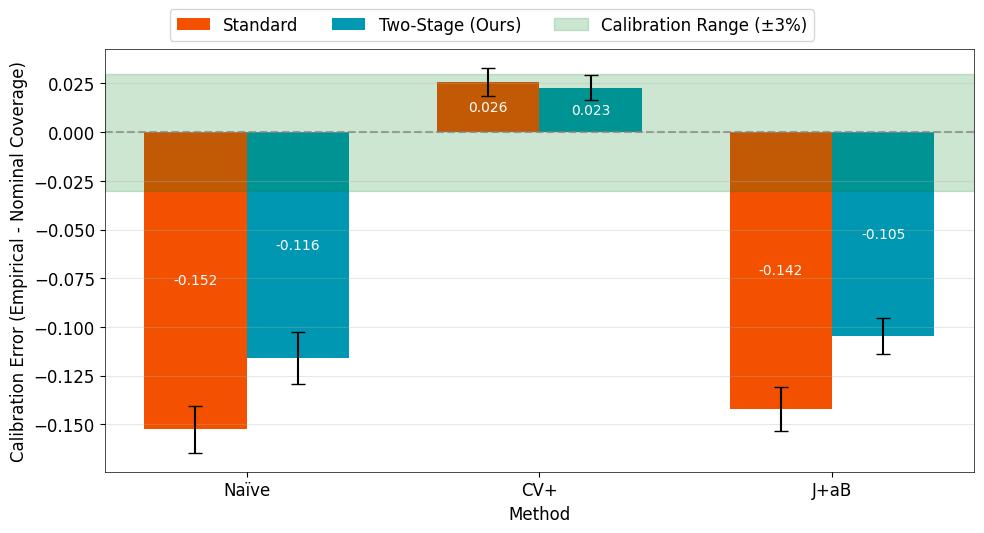

In [16]:
methods = ['Naïve', 'CV+', 'J+aB']
vanilla_means = [
    np.mean(vanilla_calib['coverage_naive']),
    np.mean(vanilla_calib['coverage_cv_plus']),
    np.mean(vanilla_calib['coverage_jackknife_plus_ab'])
]
full_means = [
    np.mean(full_calib['coverage_naive']),
    np.mean(full_calib['coverage_cv_plus']),
    np.mean(full_calib['coverage_jackknife_plus_ab'])
]
vanilla_stds = [
        sem(vanilla_calib['coverage_naive']),
        sem(vanilla_calib['coverage_cv_plus']),
        sem(vanilla_calib['coverage_jackknife_plus_ab'])
    ]
    
full_stds = [
    sem(full_calib['coverage_naive']),
    sem(full_calib['coverage_cv_plus']),
    sem(full_calib['coverage_jackknife_plus_ab'])
]

# Create the comparison plot
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(methods))
width = 0.35

# Add a green zone for "good calibration" within ±3%
vanilla_bars = ax.bar(x - width/2, vanilla_means, width, label='Standard', color=color_orange, yerr=vanilla_stds, capsize=5)
full_bars = ax.bar(x + width/2, full_means, width, label='Two-Stage (Ours)', color=color_azure, yerr=full_stds, capsize=5)

for bars in [vanilla_bars, full_bars]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height/2,
                 f'{height:.3f}',
                 ha='center', va='center',
                 color='white', fontsize=10, zorder=10)        
# Add perfect calibration reference line
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.7)

# Add labels and formatting
ax.set_xlabel('Method')
ax.set_ylabel('Calibration Error (Empirical - Nominal Coverage)')
ax.axhspan(-0.03, 0.03, alpha=0.2, color=pos_color, label='Calibration Range (±3%)')

# ax.set_title('Calibration Analysis: Vanilla vs Full Conformal')
ax.set_xticks(x, methods)
plt.grid(axis='y', alpha=0.3)

handles, labels = ax.get_legend_handles_labels()
handles = [handles[1], handles[2], handles[0]]
labels = [labels[1], labels[2], labels[0]]
fig.legend(handles, labels, loc='upper center', ncol=3, fontsize=12, 
          bbox_to_anchor=(0.5, 0.95), frameon=True)  

for spine in plt.gca().spines.values():
    spine.set_color('black')
    spine.set_linewidth(0.5)      

plt.tight_layout(rect=[0, 0.05, 1, 0.9])
plt.savefig('calibration_comparison.svg', dpi=300)
plt.show()

#### Landscape Calibration

Landscape calibration error across different classification cutoffs for standard (A) and two-stage (B) approaches. Values near zero indicate well-calibrated predictions, with CV+ maintaining better calibration throughout most cutoffs

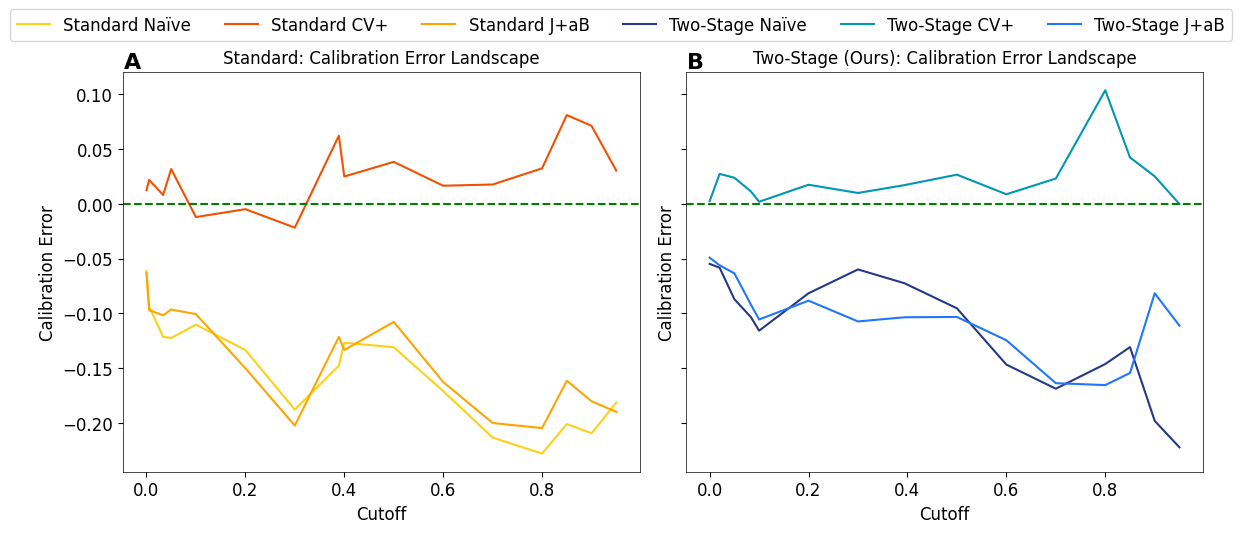

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharex=False, sharey=True)
# Performance across cutoffs for Vanilla
ax1.plot(conformal_metrics["vanilla"]['cutoff'], 
            np.array(conformal_metrics["vanilla"]['coverage_naive']) - target_coverage,
            label='Standard Naïve', color= color_yellow)
ax1.plot(conformal_metrics["vanilla"]['cutoff'], 
            np.array(conformal_metrics["vanilla"]['coverage_cv_plus']) - target_coverage,
            label='Standard CV+', color=color_orange)
ax1.plot(conformal_metrics["vanilla"]['cutoff'], 
            np.array(conformal_metrics["vanilla"]['coverage_jackknife_plus_ab']) - target_coverage,
            label='Standard J+aB', color= color_gold_2)
ax1.set_title('Standard: Calibration Error Landscape', fontsize=12)
ax1.set_xlabel('Cutoff', fontsize=12)
ax1.set_ylabel('Calibration Error', fontsize=12)
ax1.axhline(y=0, color='green', linestyle='--')

# Full Conformal landscape
ax2.plot(conformal_metrics["1_year"]['cutoff'], 
            np.array(conformal_metrics["1_year"]['coverage_naive']) - target_coverage,
            label='Two-Stage Naïve', color=color_blue)
ax2.plot(conformal_metrics["1_year"]['cutoff'], 
            np.array(conformal_metrics["1_year"]['coverage_cv_plus']) - target_coverage,
            label='Two-Stage CV+', color=color_azure)
ax2.plot(conformal_metrics["1_year"]['cutoff'], 
            np.array(conformal_metrics["1_year"]['coverage_jackknife_plus_ab']) - target_coverage,
            label='Two-Stage J+aB', color= color_blue_2)
# Add letters A and B to the subplots
ax1.text(0.035, 1.05, 'A', transform=ax1.transAxes, 
         fontsize=16, fontweight='bold', va='top', ha='right')
ax2.text(0.035, 1.05, 'B', transform=ax2.transAxes, 
         fontsize=16, fontweight='bold', va='top', ha='right')
ax2.set_title('Two-Stage (Ours): Calibration Error Landscape', fontsize=12)
ax2.set_xlabel('Cutoff', fontsize=12)
ax2.set_ylabel('Calibration Error', fontsize=12)
ax2.axhline(y=0, color='green', linestyle='--')

handles, labels = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
handles.extend(handles2)
labels.extend(labels2)
fig.legend(handles, labels, loc='upper center', ncol=6, fontsize=12, 
          bbox_to_anchor=(0.5, 0.95), frameon=True)


for ax in [ax1, ax2]:
    for spine in ax.spines.values():
        spine.set_color('black')
        spine.set_linewidth(0.5)

plt.tight_layout(rect=[0, 0.05, 1, 0.9])
plt.savefig('calibration_error_landscape.svg', dpi=300)
plt.show()